In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
dataset, info = tfds.load(
    "cats_vs_dogs",
    with_info=True,
    as_supervised=True
)

total_samples = info.splits['train'].num_examples
print("Total samples:", total_samples)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.BXOVB7_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Total samples: 23262


In [ ]:
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

train_ds = dataset['train'].take(train_size)
temp_ds = dataset['train'].skip(train_size)

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

train_ds = train_ds.map(preprocess).map(
    lambda x, y: (data_augmentation(x), y)
)

val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

baseline_model.fit(train_ds, validation_data=val_ds, epochs=5)

baseline_acc = baseline_model.evaluate(test_ds)[1]
print("Baseline Test Accuracy:", baseline_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 245s 468ms/step - accuracy: 0.5969 - loss: 0.8905 - val_accuracy: 0.6738 - val_loss: 0.6116
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 233s 458ms/step - accuracy: 0.6729 - loss: 0.6087 - val_accuracy: 0.7128 - val_loss: 0.5775
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 257s 448ms/step - accuracy: 0.7012 - loss: 0.5757 - val_accuracy: 0.7203 - val_loss: 0.5530
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 228s 448ms/step - accuracy: 0.7172 - loss: 0.5534 - val_accuracy: 0.7535 - val_loss: 0.5193
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 228s 448ms/step - accuracy: 0.7322 - loss: 0.5334 - val_accuracy: 0.7627 - val_loss: 0.4977
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7530 - loss: 0.4925
Baseline Test Accuracy: 0.7590258121490479


In [6]:
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [7]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 279s 519ms/step - accuracy: 0.5430 - loss: 0.7094 - val_accuracy: 0.5924 - val_loss: 0.6718
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 252s 495ms/step - accuracy: 0.5665 - loss: 0.6789 - val_accuracy: 0.6134 - val_loss: 0.6583
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 252s 495ms/step - accuracy: 0.5744 - loss: 0.6751 - val_accuracy: 0.6228 - val_loss: 0.6582
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 253s 496ms/step - accuracy: 0.5836 - loss: 0.6730 - val_accuracy: 0.6237 - val_loss: 0.6570
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 251s 492ms/step - accuracy: 0.5881 - loss: 0.6705 - val_accuracy: 0.6214 - val_loss: 0.6534


In [9]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 306s 563ms/step - accuracy: 0.6068 - loss: 0.9427 - val_accuracy: 0.7140 - val_loss: 0.5532
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 258s 508ms/step - accuracy: 0.6976 - loss: 0.5790 - val_accuracy: 0.6844 - val_loss: 0.6206
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 259s 508ms/step - accuracy: 0.7249 - loss: 0.5532 - val_accuracy: 0.7590 - val_loss: 0.5072
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 258s 507ms/step - accuracy: 0.7263 - loss: 0.5418 - val_accuracy: 0.7498 - val_loss: 0.5241
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 259s 509ms/step - accuracy: 0.7340 - loss: 0.5347 - val_accuracy: 0.6922 - val_loss: 0.6042


In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print("Transfer Learning Test Accuracy:", test_acc)

110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.7008 - loss: 0.6064
Transfer Learning Test Accuracy: 0.6994269490242004


In [13]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107

In [14]:
last_conv_layer = "conv5_block3_out"

grad_model = tf.keras.models.Model(
    model.inputs,
    [model.get_layer(last_conv_layer).output, model.output]
)

image, label = next(iter(test_ds))
img = image[0]

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(tf.expand_dims(img, axis=0))
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)


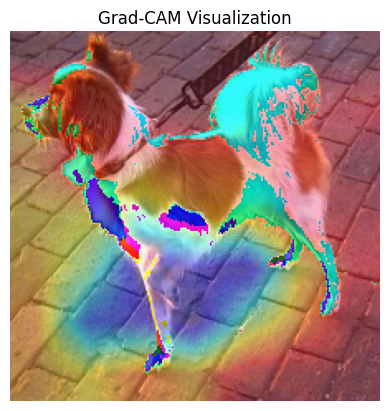

In [15]:
heatmap = cv2.resize(heatmap.numpy(), (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img.numpy() * 255

plt.imshow(superimposed_img.astype("uint8"))
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.show()


In [ ]:
model.save("cats_vs_dogs_resnet50.h5")